In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from functools import partial
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [ ]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train, X_valid = X_train_full[:-10000], X_train_full[-10000:]
y_train, y_valid = y_train_full[:-10000], y_train_full[-10000:]

In [ ]:
tf.random.set_seed(42)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1))

## Simple CNN

In [ ]:
model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu", input_shape=[32,32,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2,strides=2,padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=10,activation='softmax')
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

score = model.evaluate(X_test, y_test)

Epoch 1/3
1250/1250 [==============================] - 21s 7ms/step - loss: 1.7865 - accuracy: 0.4098 - val_loss: 1.3235 - val_accuracy: 0.5126
Epoch 2/3
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2289 - accuracy: 0.5649 - val_loss: 1.1111 - val_accuracy: 0.6006
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.9633 - accuracy: 0.6661


In [ ]:

X_test_samples = X_test[:10] 
y_pred = model.predict(X_test_samples)

1/1 [==============================] - 0s 205ms/step


## LeNet-5


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(84, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
1250/1250 [==============================] - 8s 4ms/step - loss: 2.0509 - accuracy: 0.3023 - val_loss: 1.6206 - val_accuracy: 0.4245
Epoch 2/3
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5070 - accuracy: 0.4631 - val_loss: 1.4041 - val_accuracy: 0.4972
Epoch 3/3
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3534 - accuracy: 0.5222 - val_loss: 1.3887 - val_accuracy: 0.5214


In [ ]:
score = model.evaluate(X_test, y_test)
score

313/313 [==============================] - 2s 6ms/step - loss: 1.3874 - accuracy: 0.5202


[1.3873687982559204, 0.5202000141143799]

## Transfer Learning with Efficient Net

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 10

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:

size = (IMG_SIZE, IMG_SIZE)
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(num_classes):
    inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    model.trainable = False

    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)
    outputs = tf.expand_dims(outputs, axis=1)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

hist = model.fit(train_ds, epochs=3, validation_data=test_ds, verbose=2)

(None, 1, 10)
Epoch 1/3
625/625 - 93s - loss: 0.8027 - accuracy: 0.8245 - val_loss: 0.5214 - val_accuracy: 0.8677 - 93s/epoch - 148ms/step
Epoch 2/3
625/625 - 82s - loss: 0.4908 - accuracy: 0.8572 - val_loss: 0.3711 - val_accuracy: 0.8816 - 82s/epoch - 131ms/step
Epoch 3/3
625/625 - 81s - loss: 0.4195 - accuracy: 0.8645 - val_loss: 0.3892 - val_accuracy: 0.8756 - 81s/epoch - 130ms/step


## Transfer Learning with BiT

In [ ]:

IMG_SIZE = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  
NUM_CLASSES = 10
SCHEDULE_LENGTH = (20)
SCHEDULE_BOUNDARIES = [5, 10, 15]

In [ ]:

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)

@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (CROP_TO, CROP_TO))
    image = image / 255.0
    return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
repeat_count += 10 + 1

In [ ]:
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.repeat(repeat_count)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTO)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTO)

test_ds = test_ds.map(preprocess_test, num_parallel_calls=AUTO)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTO)

In [ ]:

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [ ]:
class BiTModel(keras.Model):
  def __init__(self, num_classes, module, **kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
    self.bit_model = module

  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = BiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [ ]:

learning_rate = 0.005 * BATCH_SIZE / 512

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:

callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=3,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_ds,
    callbacks=callbacks,
)

Epoch 1/3
10/10 [==============================] - 86s 10s/step - loss: 0.8217 - accuracy: 0.7000 - val_loss: 0.6816 - val_accuracy: 0.7553
Epoch 2/3
10/10 [==============================] - 86s 10s/step - loss: 0.6968 - accuracy: 0.7563 - val_loss: 0.6228 - val_accuracy: 0.7829
Epoch 3/3
10/10 [==============================] - 86s 9s/step - loss: 0.5830 - accuracy: 0.7969 - val_loss: 0.6009 - val_accuracy: 0.7918


In [ ]:

accuracy = model.evaluate(test_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

157/157 [==============================] - 61s 389ms/step - loss: 0.6009 - accuracy: 0.7918
Accuracy: 79.18%


## Image augmentation

In [ ]:
# Create TensorFlow Datasets from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_images = train_ds.map(lambda x, y: x).as_numpy_iterator()
train_labels = train_ds.map(lambda x, y: y).as_numpy_iterator()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


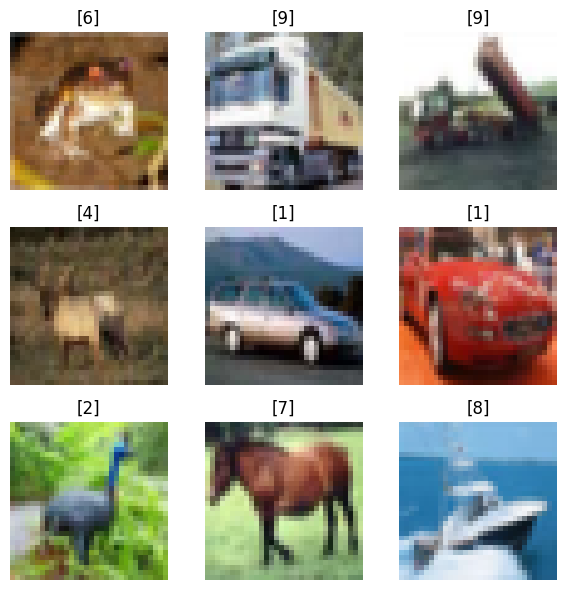

In [ ]:
# Plot 9 images from the train dataset
plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    if i >= 9:
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2)
])

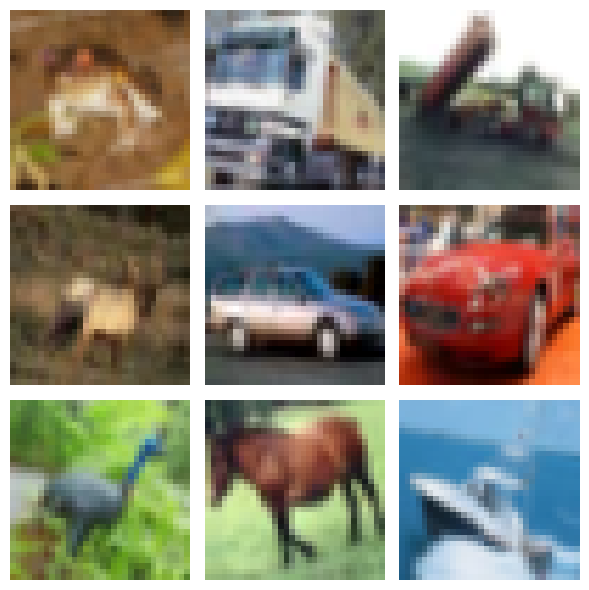

In [ ]:
# Apply data augmentation to a subset of 9 images
augmented_images = []
for image, _ in train_ds.take(9):
    augmented_image = data_augmentation(image)
    augmented_images.append(augmented_image)

# Plot the augmented images
plt.figure(figsize=(6, 6))
for i, image in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

## MLP Mixer

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

weight_decay = 0.0001
batch_size = 128
num_epochs = 3
dropout_rate = 0.2
image_size = 64  
patch_size = 8  
num_patches = (image_size // patch_size) ** 2 
embedding_dim = 256  
num_blocks = 4  
learning_rate = 0.005

In [ ]:
class Patches(keras.layers.Layer):
  def __init__(self, patch_size, num_patches):
    super().__init__()
    self.patch_size = patch_size
    self.num_patches = num_patches

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
    return patches

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = keras.layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size, num_patches)(augmented)
    x = keras.layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding

    x = blocks(x)

    representation = keras.layers.GlobalAveragePooling1D()(x)
    representation = keras.layers.Dropout(rate=dropout_rate)(representation)
    logits = keras.layers.Dense(num_classes)(representation)

    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
class MLPMixerLayer(keras.layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                keras.layers.Dense(units=num_patches),
                keras.layers.Dense(units=num_patches),
                keras.layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                keras.layers.Dense(units=num_patches),
                keras.layers.Dense(units=embedding_dim),
                keras.layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        x = self.normalize(inputs)
        x_channels = tf.linalg.matrix_transpose(x)
        mlp1_outputs = self.mlp1(x_channels)
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        x = mlp1_outputs + inputs
        x_patches = self.normalize(x)
        mlp2_outputs = self.mlp2(x_patches)
        x = x + mlp2_outputs
        return x

In [ ]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)

mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)

Epoch 1/3
282/282 [==============================] - 25s 50ms/step - loss: 1.9354 - acc: 0.3034 - top5-acc: 0.7991 - val_loss: 1.8861 - val_acc: 0.3580 - val_top5-acc: 0.8550 - lr: 0.0050
Epoch 2/3
282/282 [==============================] - 13s 45ms/step - loss: 1.6546 - acc: 0.4022 - top5-acc: 0.8839 - val_loss: 1.5963 - val_acc: 0.4313 - val_top5-acc: 0.8985 - lr: 0.0050
Epoch 3/3
313/313 [==============================] - 4s 11ms/step - loss: 1.6728 - acc: 0.4317 - top5-acc: 0.8995
Test accuracy: 43.17%
Test top 5 accuracy: 89.95%
